# COREQQA - A COmpliance REQuirements Understanding using Question Answering Tool

COREQQA is a tool for assisting requirements engineers in acquiring a better understanding of compliance requirements from legal documents by means of Question Answering (QA) system. The tool expects as input the textual context of the legal document and a question, and outputs a word document with the top-N context spans with the predicted answers to the question highlighted in these relevant context spans.

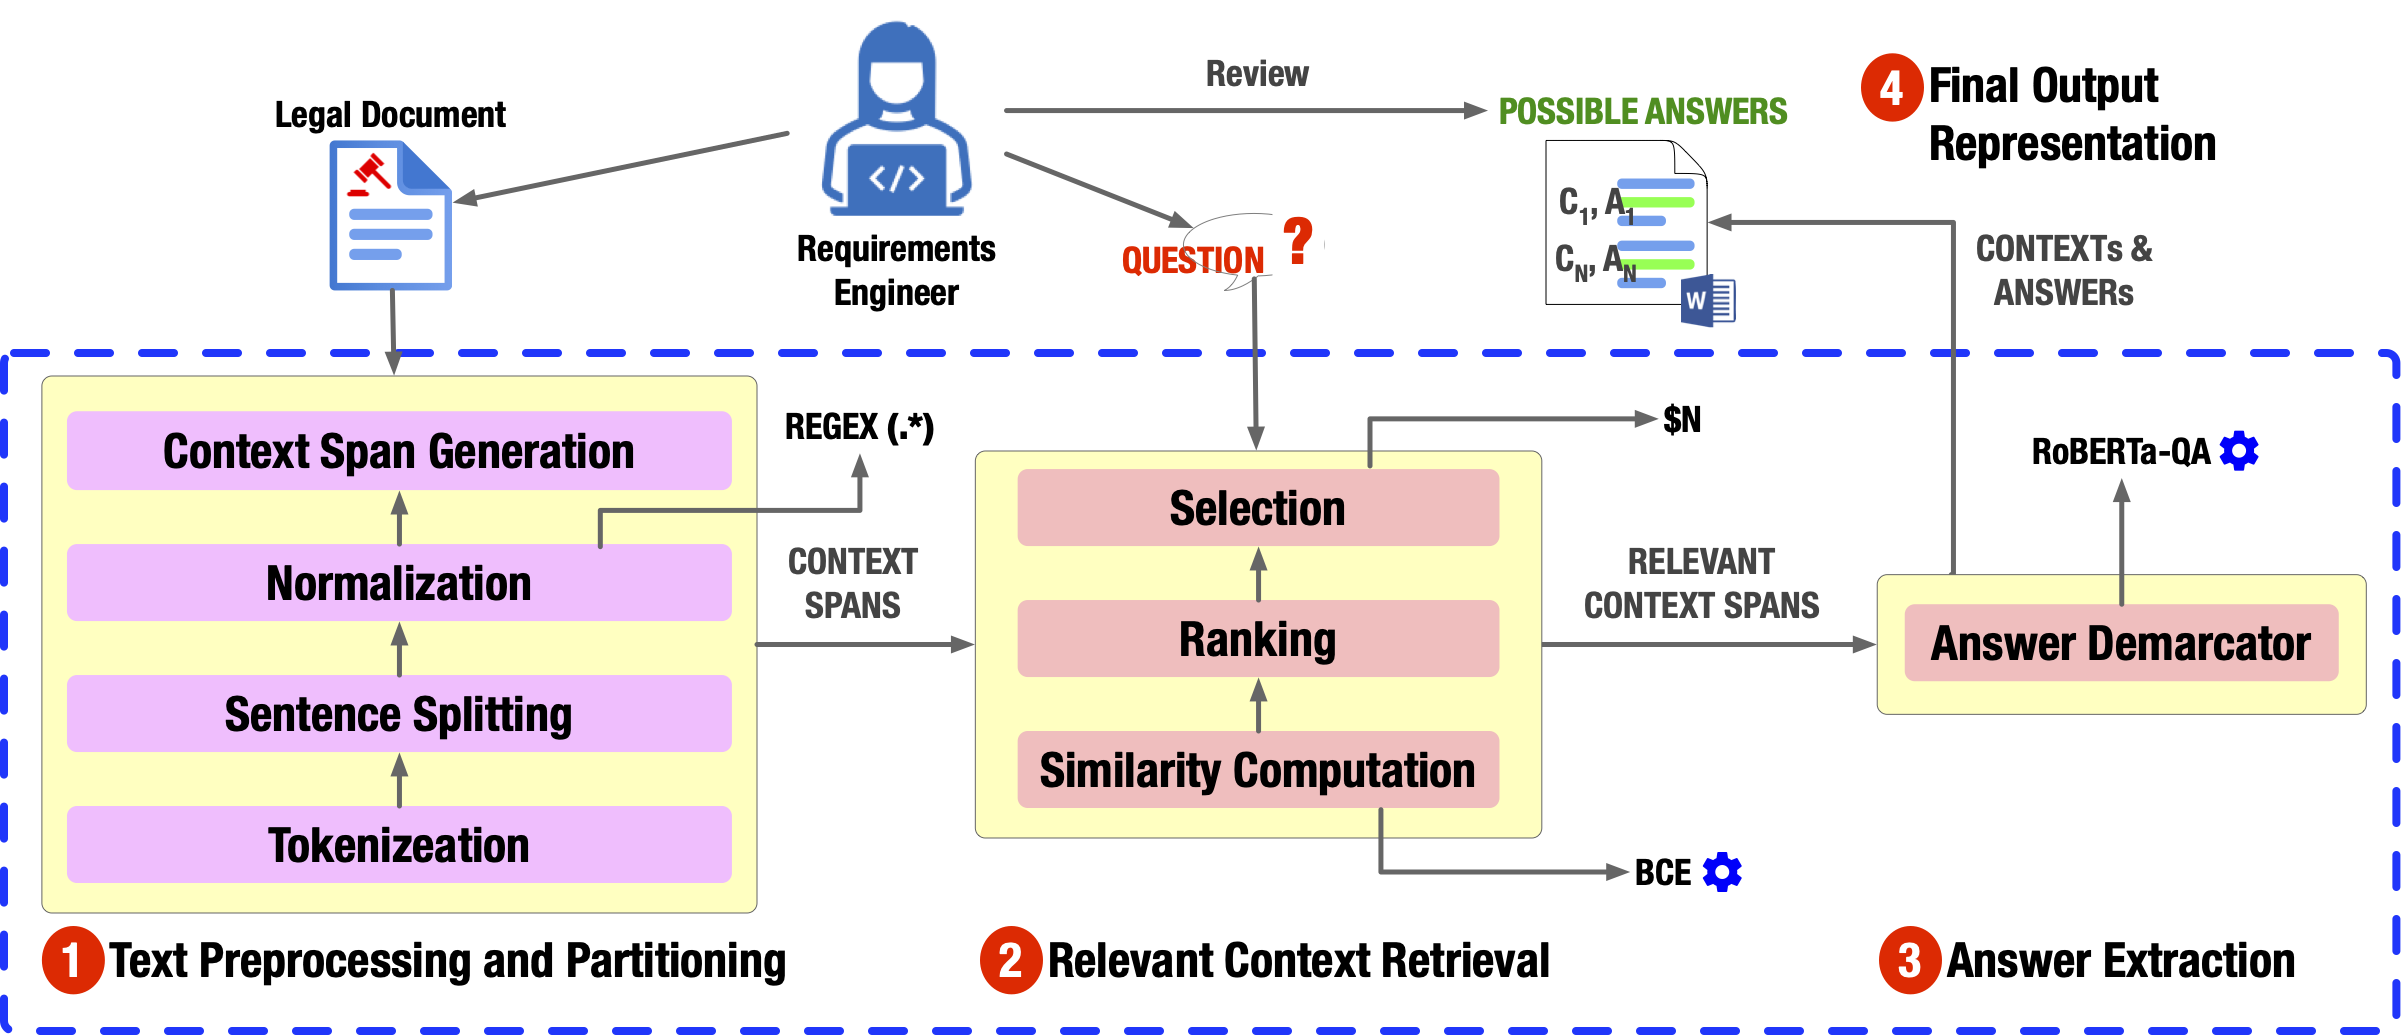

### Step 0. Import all relevant libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import textdistance
from files import dir_679_content
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import operator
from sklearn.metrics.pairwise import cosine_similarity
stop_words = set(stopwords.words('english'))

from sentence_transformers import CrossEncoder
import re
import ast
import time

from docx import Document
from docx.enum.text import WD_COLOR_INDEX
from pathlib import Path

### User Inputs

In [2]:
question = 'What is the procedure for handling personal data breach?'

In [3]:
'''
    Import the legal document content
'''
law_name = "Directive 2016/679"
law_doc = dir_679_content.dir_679

In [4]:
'''
    Select top-N context spans
'''
TOP_N_VAL = 5

### Step 1. Text Preprocessing and Partitioning

In [5]:
'''
Preprocessing step for splitting the legal text into sentences.
'''
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She\s|It\s|They\s|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    if len(sentences) > 1:
        sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

def Merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [6]:
'''
    Partition the content into context spans of maximum length 512 (Context Span Generation)
'''

MAX_LEN = 512

def sub_paragraph(law):
    var_dict={}
    counter_large_spans = 0
    for k,v in law.items():
        list_var=[]        
        if len(word_tokenize(law[k])) > MAX_LEN:
            counter_large_spans = counter_large_spans + 1
        counter_sub_elements=len(word_tokenize(law[k]))//MAX_LEN
        for i in range(counter_sub_elements):
            list_var.append(" ".join(word_tokenize(law[k])[MAX_LEN*i:MAX_LEN*(i+1)]))
        list_var.append(" ".join(word_tokenize(law[k])[MAX_LEN*counter_sub_elements:]))
        var_dict[k]=list_var
    #print("Num_large_spans = ", counter_large_spans)
    return var_dict

### Execute Step 1

In [7]:
var_dic = sub_paragraph(law_doc)

### Step 2. Relevant Context Span Retrieval (using BCE)

#### Step 2.1. Similarity Calculation using BCE

In [8]:
'''
Cross Encoder - Step B
'''
def crossEncoderTopN(var_dic, QID, data_crossEncoder):
    ## Load our cross-encoder. Use fast tokenizer to speed up the tokenization
    model = CrossEncoder('cross-encoder/ms-marco-TinyBERT-L-2')
    
    row = data_crossEncoder.loc[data_crossEncoder["QID"] == QID]
    row = row.head(1)
    question = row.iloc[0]["Question"]
    context_spans = {}
    num_sents = 0
    
    ##Iterate over all context spans at article level
    for k in var_dic.keys():     
        passages = []
        window_size = 1        
        for l in range(len(var_dic[k])): ##Individual sub-articles (context-spans in articles)
            context = split_into_sentences(var_dic[k][l]) ##Split context span in sentences
            num_sents = num_sents + len(context)            
            for start_idx in range(0, len(context), window_size):
                end_idx = min(start_idx+window_size, len(context))
                passages.append(" ".join(context[start_idx:end_idx]))    ##Build passage of interest.
            #Concatenate the query and all passages and predict the scores for the pairs [query, passage]
            model_inputs = [[question, span] for span in passages]
            scores = model.predict(model_inputs)
            #Sort the scores in decreasing order
            results = [{'input': inp, 'score': score} for inp, score in zip(model_inputs, scores)]
            results = sorted(results, key=lambda x: x['score'], reverse=True)
            key = law_name + "_" + str(k) + "_" + str(l)
            context_spans[key] = var_dic[k][l]                        
            row["Context_span"] = key
            row["CS_CrossEncoderScore"] = results[0]['score']
            data_crossEncoder = data_crossEncoder.append(row)
    return data_crossEncoder, context_spans

### Execute Step 2.1

In [9]:
column_names = ['QID', 'Document', 'Question', 'Context_span', 'CS_CrossEncoderScore']
data_crossEncoder = pd.DataFrame(columns=column_names)
data_crossEncoder["Context_span"] = ""
data_crossEncoder["CS_CrossEncoderScore"] = 0.0
relevant_Questions = ['Q1']
df_row = {'QID': 'Q1', 'Document': law_name, 'Question': question, 'Context_span': '', 'CS_CrossEncoderScore': 0.0}
data_crossEncoder = data_crossEncoder.append(df_row, ignore_index = True)
data_crossEncoder, context_spans = crossEncoderTopN(var_dic,'Q1', data_crossEncoder)

#### Step 2.2. Ranking the context spans based on the similarity calculation in Step 2.1

In [10]:
'''
Ranking Process
'''
max_CrossEncoder_Scores = data_crossEncoder.groupby(['QID'], sort=False)['CS_CrossEncoderScore'].max()
data_crossEncoder['Relative_CrossEncoder'] = data_crossEncoder.apply(lambda row: row.CS_CrossEncoderScore/max_CrossEncoder_Scores[row.QID], axis = 1)
data_crossEncoder = data_crossEncoder.sort_values(["QID", "Relative_CrossEncoder"], ascending = (True, False))
data_crossEncoder["CrossEncoder_Rank"] = data_crossEncoder.groupby(['QID'], sort=False).rank(method='min',ascending=False)["Relative_CrossEncoder"]

#### Step 2.3. Top-N Context Span Selection

In [11]:
df_QuestionAnswering = data_crossEncoder[(data_crossEncoder.CrossEncoder_Rank <= TOP_N_VAL) & (data_crossEncoder.QID.isin(relevant_Questions))]
df_QuestionAnswering["PredictedAnswer"] = ''
df_QuestionAnswering["PredictedConfidence"] = 0.0
df_QuestionAnswering

<ipython-input-11-6e3b2d98fbb2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_QuestionAnswering["PredictedAnswer"] = ''
<ipython-input-11-6e3b2d98fbb2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_QuestionAnswering["PredictedConfidence"] = 0.0


,QID,Document,Question,Context_span,CS_CrossEncoderScore,Relative_CrossEncoder,CrossEncoder_Rank,PredictedAnswer,PredictedConfidence
0,Q1,Directive 2016/679,What is the procedure for handling personal da...,Directive 2016/679_86_0,0.912293,1.000000,1.0,,0.0
0,Q1,Directive 2016/679,What is the procedure for handling personal da...,Directive 2016/679_122_0,0.899824,0.986333,2.0,,0.0
0,Q1,Directive 2016/679,What is the procedure for handling personal da...,Directive 2016/679_207_0,0.882690,0.967552,3.0,,0.0
0,Q1,Directive 2016/679,What is the procedure for handling personal da...,Directive 2016/679_206_0,0.878033,0.962447,4.0,,0.0
0,Q1,Directive 2016/679,What is the procedure for handling personal da...,Directive 2016/679_88_0,0.871602,0.955397,5.0,,0.0


### Step 3. Answer Extraction (using RoBERTa)

In [12]:
model = 'Roberta'
model_name = "deepset/roberta-base-squad2-distilled"

nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)
df_QuestionAnswering = df_QuestionAnswering.reset_index()

In [13]:
for i,r in df_QuestionAnswering.iterrows():
    question = r['Question']
    span_id = r['Context_span']
    span = context_spans[span_id]
    QA_input = {
        'question': question,
        'context': span
    }
    res = nlp(QA_input)
    df_QuestionAnswering.at[i,'PredictedAnswer'] = res['answer']
    df_QuestionAnswering.at[i,'PredictedConfidence'] = res['score']
    df_QuestionAnswering.at[i,'PredictedAnswer_Start'] = res['start']
    df_QuestionAnswering.at[i,'PredictedAnswer_End'] = res['end']    

### Step 4. Export the Relevant Context Spans and Highlighted Answers as a Word Document 

In [14]:
df_QuestionAnswering = df_QuestionAnswering.sort_values(["PredictedConfidence", "Relative_CrossEncoder"], ascending = (False, False))
for val, cnt in df_QuestionAnswering.QID.value_counts().iteritems():
    df_subset = df_QuestionAnswering[df_QuestionAnswering['QID'] == val]
    document = Document()
    question = df_subset['Question'].iloc[0]
    document.add_heading('Ques: ' + question, 0)
    counter = 1
    for i,r in df_subset.iterrows():
        span_id = r['Context_span']
        span = context_spans[span_id]        
        predicted_answer = df_QuestionAnswering.at[i,'PredictedAnswer']
        predicted_conf = str(df_QuestionAnswering.at[i,'PredictedConfidence'])
        crossEncoder_Rank = str(df_QuestionAnswering.at[i,'CrossEncoder_Rank'])
        
        start = int(df_QuestionAnswering.at[i,'PredictedAnswer_Start'])
        end = int(df_QuestionAnswering.at[i,'PredictedAnswer_End'])
        

        # Create a new paragraph with predicted answer highlighted
        p2 = document.add_paragraph()
        p2.add_run("\n Context Span: " + str(counter) + " \n")
        counter+=1 
                
        p2.add_run(span[0:start])
        font = p2.add_run(predicted_answer).font
        font.highlight_color = WD_COLOR_INDEX.YELLOW        
        p2.add_run(span[end:])                
        p2.add_run( " \n" + "Prediction Confidence Score: " + predicted_conf + " \n")
        
    document.save(val+'_demo.docx')
    print("Document Saved - " + val+'_demo.docx')        
        

Document Saved - Q1_demo.docx
